In [0]:
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

# Importing Time Series stats stuff
! pip install pmdarima
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA, ARMAResults, ARIMA, ARIMAResults
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import mse, rmse, meanabs

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

# Importing Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.preprocessing.sequence import TimeseriesGenerator

     |████████████████████████████████| 1.1MB 9.1MB/s 


Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# Follow the instructions in the output after executing this code (go to the URL, authorize, and copy the authorization code)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Data Visualization

In [0]:
# You need to move the CS3244 Folder from "Shared With Me" into "My Drive"
df = pd.read_csv('/content/drive/My Drive/CS3244/Colab/datasets/AEP_data.csv', index_col="date", parse_dates=True)
df = df.resample('B').pad()
df.index.freq = 'B'
df.drop('Name', axis=1, inplace=True)
df.head(5)

,open,high,low,close,volume
date,,,,,
2013-02-08,44.55,44.63,44.25,44.57,2312792
2013-02-11,44.57,44.74,44.48,44.73,1372326
2013-02-12,44.73,44.94,44.60,44.90,1695150
2013-02-13,44.87,45.04,44.76,44.93,1324472
2013-02-14,44.76,44.81,44.41,44.77,3665271


In [0]:
def get_summary(df):
    print("Shape: ", df.shape)
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name', 'dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Percentage Missing'] = df.isnull().sum().values / df.shape[0]
    summary['Uniques'] = df.nunique().values
    return summary

get_summary(df)

Shape:  (1304, 5)


,Name,dtypes,Missing,Percentage Missing,Uniques
0,open,float64,0,0.0,983
1,high,float64,0,0.0,1010
2,low,float64,0,0.0,1038
3,close,float64,0,0.0,976
4,volume,int64,0,0.0,1256


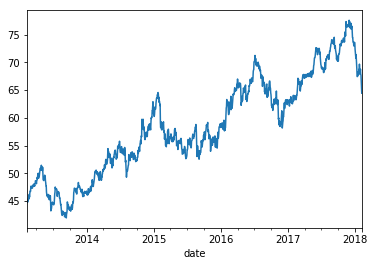

In [0]:
df_ffill = df.iloc[1:]
df_ffill = df_ffill.fillna(method='ffill')
df_ffill['close'].asfreq('B').plot()
plt.show()

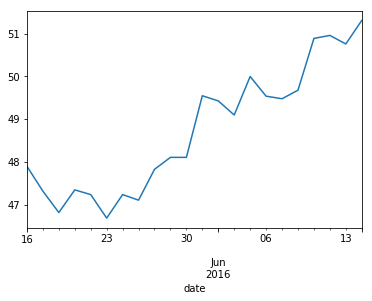

In [0]:
df_ffill.loc['2016-05-14':'2016-06-14']['close'].asfreq('B').plot()

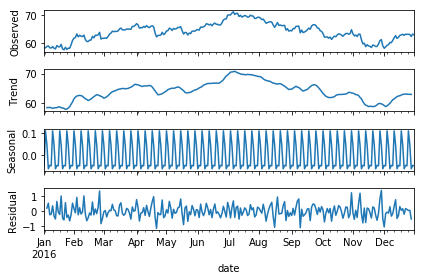

In [0]:
result = seasonal_decompose(df.loc['2016-01-01':'2017-01-01']['close'], model='additive')
result.plot();

# Data Preprocessing

In [0]:
df['target_reg'] = df['open'].shift(-1)
df = df.iloc[:-1]
df['target_class'] = df['target_reg'] > df['open']
df.tail()
df.head()

,open,high,low,close,volume,target_reg,target_class
date,,,,,,,
2013-02-08,44.55,44.63,44.25,44.57,2312792,44.57,True
2013-02-11,44.57,44.74,44.48,44.73,1372326,44.73,True
2013-02-12,44.73,44.94,44.60,44.90,1695150,44.87,True
2013-02-13,44.87,45.04,44.76,44.93,1324472,44.76,False
2013-02-14,44.76,44.81,44.41,44.77,3665271,44.84,True


# Feature Engineering?

In [0]:
# df['range'] = df['high'] - df['low']
# df['range'] = df['range'].abs()
# df = df.drop(['high', 'low'], axis=1)

# KNN Regressor
Using pure Regression and not Time Series. Structured the problem as the regression problem

In [0]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
y = df['target_reg']
x = df.drop('target_reg', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

regressor = KNeighborsRegressor(n_neighbors=5)
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)
regressor.score(x_test, y_test)


0.9981546699280637

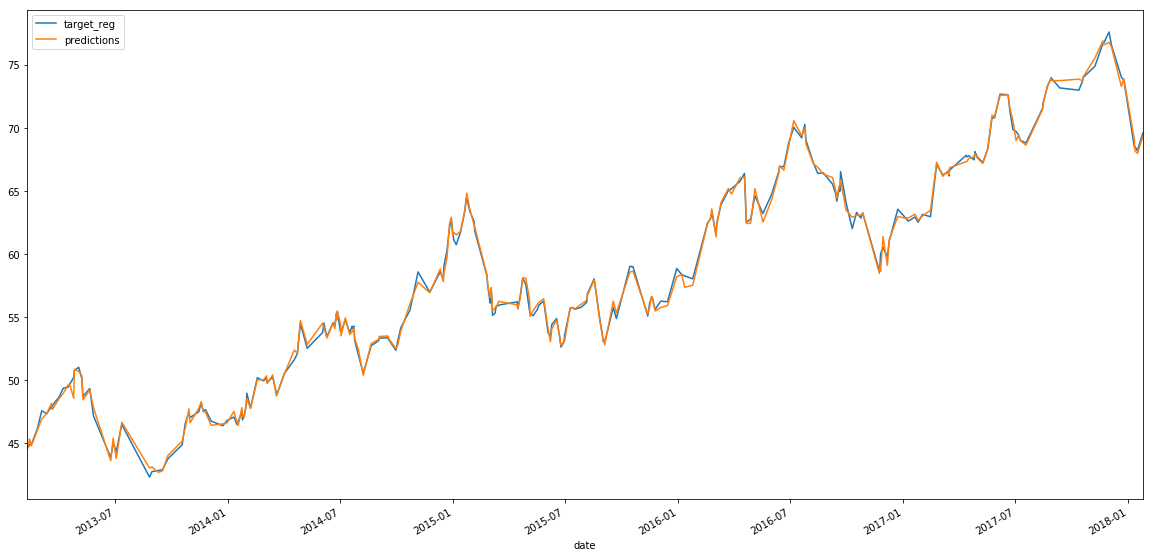

In [0]:
y_test['predictions'] = pd.Series(y_pred)
y_test = pd.DataFrame(y_test, columns=['target_reg'])
y_pred = pd.DataFrame(y_pred, columns=['predictions'])
y_test = y_test.reset_index()
y_test = pd.concat([y_test, y_pred], axis=1)
y_test = y_test.iloc[:-1]
y_test['date'] = pd.to_datetime(y_test['date'])
y_test.set_index('date', inplace=True)
y_test.plot(figsize=[20, 10])

# KNN Classifier
Classifying whether the opening stock price on the next day increases or decreases. \\
0.64 accuracy, 0.050 std - using K-fold cross validation

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
y = df['target_class']
x = df.drop('target_class', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
classifier.score(x_test, y_test)

0.6130268199233716

In [0]:
y_test = pd.DataFrame(y_test, columns=['target_class'])
y_pred = pd.DataFrame(y_pred, columns=['predictions'])
y_test = y_test.reset_index()
y_test = pd.concat([y_test, y_pred], axis=1)
score = y_test['target_class'] == y_test['predictions']
score = score.astype(int)
score = score.sum() / score.shape[0]
print("Test score: ", score)

Test score:  0.5692307692307692


# Random Forest Classifier

0.76 accuracy, 0.052 std  - using K-fold cross validation, better than KNN. Random Forest Classifier's score function is weird.

In [0]:
from sklearn.ensemble import RandomForestClassifier

y = df['target_class']
x = df.drop('target_class', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

classifier = RandomForestClassifier(n_estimators=10, criterion='entropy')
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
print(classifier.score(x_test, y_test))
cm = confusion_matrix(y_test, y_pred)
cm

0.735632183908046


array([[102,  30],
       [ 39,  90]])

In [0]:
y_test = pd.DataFrame(y_test, columns=['target_class'])
y_pred = pd.DataFrame(y_pred, columns=['predictions'])
y_test = y_test.reset_index()
y_test = pd.concat([y_test, y_pred], axis=1)
score = y_test['target_class'] == y_test['predictions']
score = score.astype(int)
score = score.sum() / score.shape[0]
print("Test score: ", score)

Test score:  0.6153846153846154


# AdaBoost

0.59 accuracy, 0.048 std - using K-fold cross validation.

In [0]:
from sklearn.ensemble import AdaBoostClassifier
y = df['target_class']
x = df.drop('target_class', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

classifier = AdaBoostClassifier()
classifier.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

# XGBoost

0.73 accuracy, 0.036 std - using K-fold cross validation.

In [0]:
from xgboost import XGBClassifier
y = df['target_class']
x = df.drop('target_class', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

classifier = XGBClassifier()
classifier.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

# K-Fold Cross Validation

In [0]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = x_train, y = y_train, cv = 10)
# accuracies = cross_val_score(estimator = classifier, X = scaled_x_train, y = y_train, cv = 10)
print("Mean: ", accuracies.mean())
print("Std: ", accuracies.std())

Mean:  0.7323162274618584
Std:  0.03739148605712468


# Time Series Exploration

Using Regression instead of Classification

In [0]:
# Test Train split
num_observations = 20
train, test = df[0:-num_observations], df[-num_observations:]

In [0]:
# Test if dataset is stationary
def adf_test(series, title=''):
  print(f'Augmented Dickey-Fuller Test: {title}')
  result = adfuller(series.dropna(), autolag='AIC')
  labels = ['ADF Test Statistic', 'p-value', '# lags used', '# observations']
  out = pd.Series(result[0:4], index=labels)
  return out
adf_test(df['close'].diff())

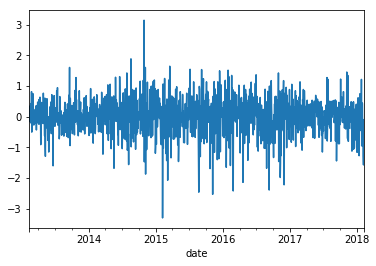

In [0]:
df['close'].diff().plot()

# AUTO ARIMA and SARIMAX

In [0]:
# Training Models (ARIMA?)
model = auto_arima(train['close'], start_p=0, start_q=0,max_p=3, max_q=3, m=52, seasonal=True, d=1, trace=True, error_action='ignore',suppress_warnings=True)
model.fit(train['close'])
ARIMA_forecast = model.predict(n_periods=num_observations)
ARIMA_forecast = pd.DataFrame(ARIMA_forecast,index = test.index,columns=['close'])

Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 1, 52); AIC=2320.118, BIC=2340.746, Fit time=8.532 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 52); AIC=2316.128, BIC=2326.442, Fit time=0.161 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 52); AIC=2317.946, BIC=2338.574, Fit time=9.912 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 52); AIC=2317.833, BIC=2338.461, Fit time=10.056 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 0, 52); AIC=2318.118, BIC=2333.589, Fit time=8.197 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 1, 52); AIC=2318.118, BIC=2333.589, Fit time=8.346 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 52); AIC=2315.952, BIC=2331.422, Fit time=0.132 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 52); AIC=2317.616, BIC=2338.244, Fit time=0.528 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 52); AIC=2316.864, BIC=2342.649, Fit time=0.958 seconds
Fit ARIMA: order=(1, 1, 0) 

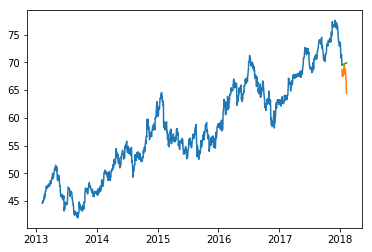

In [0]:
plt.plot(train['close'])
plt.plot(test['close'])
plt.plot(ARIMA_forecast['close'])

In [0]:
model = SARIMAX(train['close'], order=(1, 1, 0), seasonal_order=(1, 1, 1, 12))
results = model.fit()
start=len(train)
end=len(train) + len(test) - 1
SARIMAX_forecast = results.predict(start=start, end=end, dynamic=False, typ='levels').rename("SARIMAX(1, 1, 0)(1, 1, 1, 12) Predictions")

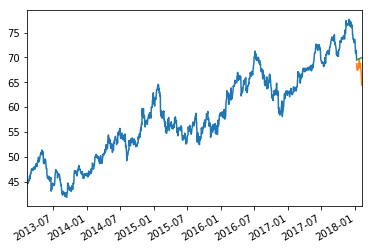

In [0]:
plt.plot(train['close'])
plt.plot(test['close'])
SARIMAX_forecast.plot()


In [0]:
# Evaluate Model
RMSE = rmse(test['close'], forecast['close'])
MSE = mse(test['close'], forecast['close'])
MAE = meanabs(test['close'], forecast['close'])
print(f'Model RMSE: {RMSE:.3f}')
print(f'Model MSE: {MSE:.3f}')
print(f'Model MAE: {MAE:.3f}')

# Keras

Using only the past closing data

In [0]:
train_2 = train['close'].to_frame()
test_2 = test['close'].to_frame()
scaler = MinMaxScaler()
scaler.fit(train_2)
scaled_train = scaler.transform(train_2)
scaled_test = scaler.transform(test_2)
n_input = num_observations
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [0]:
X, y = generator[0]
print(f'Input: \n{X.flatten()}')
print(f'Predict: \n{y}')

Input: 
[0.07420891 0.07868944 0.08345001 0.08429011 0.07980958 0.08989079
 0.08989079 0.10193223 0.10221227 0.09633156 0.11929432 0.10529264
 0.12349482 0.13273593 0.13637637 0.1341361  0.15513862 0.16073929
 0.16073929 0.15317838]
Predict: 
[[0.15597872]]


In [0]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, activation='relu', input_shape=(n_input, n_features)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator, epochs=1)

Epoch 1/1
1264/1264 [==============================] - 37s 29ms/step - loss: 0.0046


In [0]:
scaled_test[0]

array([0.75077009])

In [0]:
scaled_train[-num_observations:]
first_eval_batch = scaled_train[-num_observations:]
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
model.predict(first_eval_batch)

test_predictions = []
first_eval_batch = scaled_train[-num_observations:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
np.append(current_batch[:, 1:, :], [[[99]]], axis=1)

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[scaled_test[i]]], axis=1)
  
true_predictions = scaler.inverse_transform(test_predictions)
test['predictions'] = true_predictions

,open,high,low,close,volume,predictions
date,,,,,,
2018-01-11,69.59,69.8200,68.3800,68.73,2794211,69.943788
2018-01-12,68.47,68.5000,67.2300,67.46,6646960,69.487712
2018-01-15,68.47,68.5000,67.2300,67.46,6646960,68.921817
2018-01-16,67.75,67.9334,67.1111,67.50,3999858,68.360725
2018-01-17,68.18,68.5500,67.7400,68.25,2934657,67.862341


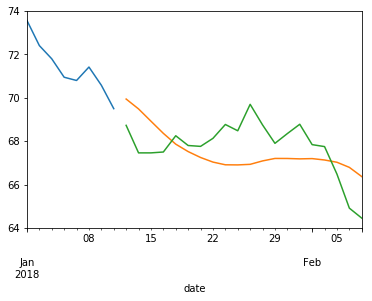

In [0]:
train.loc['2018-01-01':]['close'].plot()
test['predictions'].plot()
test['close'].plot()
test.head()

# Keras 2

Testing to use all 5 features ('open', 'high', 'low', 'close', 'volumne') as input to the Neural Network

In [0]:
# Test Train split
num_observations = 10 # how many days to look back
train, test = df[0:-num_observations], df[-num_observations:]
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)
n_input = num_observations
n_features = 5 # number of features
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1) # look back up to 20 observations ago

In [0]:
X, y = generator[0]
print(f'Input: \n{X.flatten()}')
print(f'Predict: \n{y}')

Input: 
[0.06866592 0.0640918  0.06847765 0.07420891 0.13858452 0.06922646
 0.06717045 0.07498585 0.07868944 0.06238259 0.07371076 0.07276798
 0.07838144 0.08345001 0.08853963 0.07763453 0.07556675 0.08290889
 0.08429011 0.05850518 0.07455157 0.06912958 0.07300509 0.07980958
 0.2481701  0.07679372 0.08004198 0.08290889 0.08989079 0.30650788
 0.07679372 0.08004198 0.08290889 0.08989079 0.30650788 0.08688341
 0.09347887 0.09366157 0.10193223 0.22654628 0.09893498 0.09935628
 0.10398981 0.10221227 0.22017587 0.0933296  0.09009236 0.09620826
 0.09633156 0.15222771]
Predict: 
[[0.09697309 0.10747271 0.10384833 0.11929432 0.12714741]]


In [0]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, activation='relu', input_shape=(n_input, n_features)))
model.add(LSTM(100))
model.add(Dense(5))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator, epochs=1)

Epoch 1/1
1284/1284 [==============================] - 33s 25ms/step - loss: 0.0046


In [0]:
scaled_train[-num_observations:]
batch = scaled_train[-num_observations:]
current_batch = batch.reshape((1, n_input, n_features))

# current_batch = np.append(current_batch[:, 1:, :], [[[99, 99, 99, 99, 99]]], axis=1)

for i in range(len(test)):
    # print(i)
    # print(current_batch)
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[scaled_test[i]]], axis=1)
  
true_predictions = scaler.inverse_transform(test_predictions)
true_predictions = pd.DataFrame(true_predictions, columns=['open', 'high', 'low', 'close', 'volume'])
test['predictions'] = true_predictions['close']
for i in range(len(test)):
  test.iat[i, 5] = true_predictions.iloc[i]['close']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


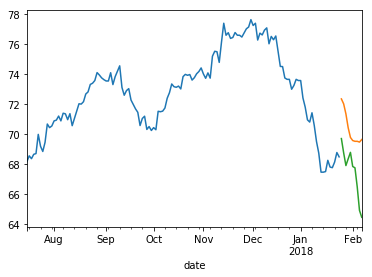

In [0]:
train.loc['2017-07-14':]['close'].plot()
test['predictions'].plot()
test['close'].plot()

In [0]:
# Invert differencing
# df_forecast['open_forecast'] = (df['open'].iloc[-num_observations-1]-df['open'].iloc[-num_observations-2]) + df_forecast['open'].cumsum()
# df_forecast['close_forecast'] = (df['close'].iloc[-num_observations-1]-df['close'].iloc[-num_observations-2]) + df_forecast['close'].cumsum()
# pd.concat([df.iloc[-num_observations:], df_forecast[['open_forecast', 'close_forecast']]], axis=1)

# Things to try:
- Time Series to predict only 1 day ahead - find a way to do cross validation for this. Test the accuracy against normal Classifiers.
- Feature Engineering - adding slope (gradient) of trendline from ARIMA models as a feature, then feed it into a Classification model.
- Dropout regularization for Keras
- Try out Neural Networks for Classification (not Time Series)